In [1]:

import re
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import numpy as np
import matplotlib.pyplot as plt

import os
import pickle #for reading images


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import seaborn as sns
import scipy.ndimage
from skimage import measure, morphology

from keras.layers import Conv2D, MaxPool3D, Flatten, Dense
from keras.layers import Dropout, Input, BatchNormalization
from sklearn.metrics import confusion_matrix, accuracy_score
from plotly.offline import iplot, init_notebook_mode
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta


from keras.models import Model

import keras



from pathlib import Path

import matplotlib.patches as patch

from PIL import Image
from skimage.transform import resize    

import cv2


from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
print(os.listdir("../input"))

Using TensorFlow backend.


['vol08', 'vol02', 'vol05', 'vol03', 'vol04', 'vol06', 'vol07', 'vol01', 'metadata.csv']


Column names:
('examId', 'seriesNo', 'aclDiagnosis', 'kneeLR', 'roiX', 'roiY', 'roiZ', 'roiHeight', 'roiWidth', 'roiDepth', 'volumeFilename')

Shape of volume "../input/vol01/404663-8.pck": (33, 320, 320)


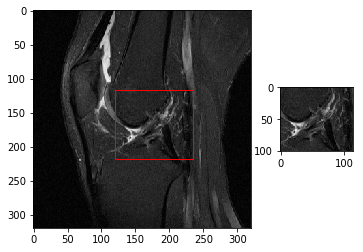

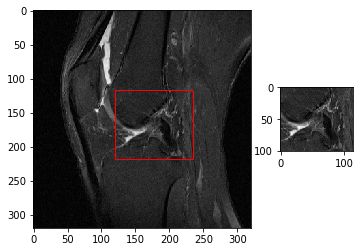

In [2]:
# directory where the volumetric data is located
volumetric_data_dir = '../input/vol01'

# path to metadata csv file
metadata_csv_path = '../input/metadata.csv'

# names=True loads the interprets the first row of csv file as column names
# 'i4' = 4 byte signed integer, 'U20' = unicode max 20 char string
metadata = np.genfromtxt(metadata_csv_path, delimiter=',', names=True, 
    dtype='i4,i4,i4,i4,i4,i4,i4,i4,i4,i4,U20') 

print('Column names:')
print(metadata.dtype.names)

# Select all rows where examID == 502889
exams = metadata[metadata['examId'] == 404663]

for exam in exams:
    vol_data_file = exam['volumeFilename']

    vol_data_path = os.path.join(volumetric_data_dir, vol_data_file)

    # Load data from file
    with open(vol_data_path, 'rb') as file_handler: # Must use 'rb' as the data is binary
        volumetric_data = pickle.load(file_handler)
    
    print('\nShape of volume "%s":' % vol_data_path, volumetric_data.shape)
    
    # Get all roi slices from volume
    z_start = exam['roiZ']
    depth = exam['roiDepth']
    
    for z in range(z_start, z_start + depth):
    
        slice = volumetric_data[z, :, :]
        
        # Get roi dimensions
        x, y, w, h = [exam[attr] for attr in ['roiX', 'roiY', 'roiWidth', 'roiHeight']]
        
        # Extract ROI
        roi = slice[y:y+h, x:x+w]
        
        # Plot slice and roi
        figure = plt.figure()
        plot = plt.subplot2grid((1, 4), (0, 0), 1, 3) # This makes the slice plot larger than roi plot
        plot.add_patch(patch.Rectangle((x, y), w, h, fill=None, color='red'))
        plot.imshow(slice, cmap='gray')
        plot = plt.subplot2grid((1, 4), (0, 3), 1, 1)
        plot.imshow(roi, cmap='gray')
        
        plt.show()

In [3]:

a=[]
df=pd.read_csv("../input/metadata.csv")
8#df = df.sample(n=15)     # k rows
for MRI in df['volumeFilename']:
    for Dir in ("vol01","vol02","vol03","vol04","vol05","vol06","vol07","vol08"):
    
        my_file=Path("../input/"+Dir+"/"+MRI )
    
        if my_file.exists():
            a.append(my_file)
    

df['path']="Image Not Here"
string1=[]
new_df=pd.DataFrame()
for i in a:
    string1.append(str(i))
string1
for b in string1:
    for i, row in df.iterrows():
        
        string1=b.split('/')
        if re.match(row['volumeFilename'],string1[3]):
            row['path']=b
            df1=row.to_frame()
            df1_transposed = df1.T
            frames = [df,df1_transposed]
            df=pd.concat(frames)
            break
            

([<matplotlib.patches.Wedge at 0x7f38965256d8>,
 [Text(-0.7606055038866715, 0.7946566978622296, '0'),
  Text(0.5947948880144476, -0.9253210476325938, '1'),
  Text(1.0797425932889912, -0.21013312979529042, '2')])

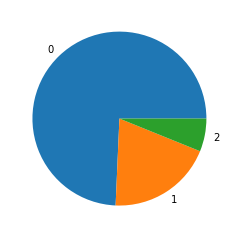

In [4]:
# Droping records for which we dont have Images
df=df[df['path']!="Image Not Here"]
sizes=df.aclDiagnosis
x=pd.value_counts(sizes)

idx = pd.Int64Index([0,1,2])
Pie_Chart_df = pd.DataFrame(index = idx, data =(x))
plt.pie(Pie_Chart_df.aclDiagnosis,labels=Pie_Chart_df.index)


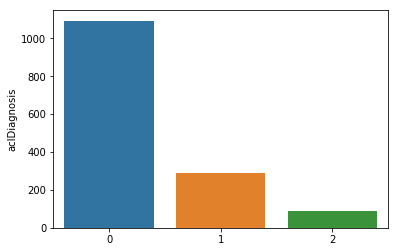

In [5]:
sns.barplot(x=Pie_Chart_df.index,y=Pie_Chart_df.aclDiagnosis)

This is our **ROI** so that we will focous only this part

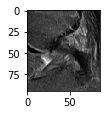

(95, 86)


In [6]:
#taking record 6 to only visulaize the image
with open(df['path'].iloc[6], 'rb') as file_handler: # Must use 'rb' as the data is binary
    volumetric_data = pickle.load(file_handler)
img=volumetric_data[df['roiZ'].iloc[6], :, :]

x=df["roiX"].iloc[6]
y=df["roiY"].iloc[6]
w=df["roiWidth"].iloc[6]
h=df["roiHeight"].iloc[6]
image_array=img[y:y+h, x:x+w]
figure = plt.figure()
plot = plt.subplot2grid((1, 4), (0, 3), 1, 1)
        
plot.imshow(image_array, cmap='gray')
        
        
        
plt.show()
print(image_array.shape)

First we will classify** Binary data** lets see what will be the results
Now Binary Calssifying The clases 
* 1==> Ruptured
* 0==> Healthy

In [7]:
#making binary dataset
new_df0=df[df.aclDiagnosis==0]
#selecting equal number of labels from dataset

new_df0=new_df0.sample(200) #200 class having Healthy knee
new_df1=df[df.aclDiagnosis!=0] #almost 200 class having ruptured knee
new_df1['aclDiagnosis']=new_df1.aclDiagnosis.replace(2,1) 
frames = [new_df1, new_df0]
new_df = pd.concat(frames)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



([<matplotlib.patches.Wedge at 0x7f38965e42b0>,
 [Text(0.5116026827081954, 0.9737878080186554, '0'),
  Text(-0.5116026827081955, -0.9737878080186554, '1')])

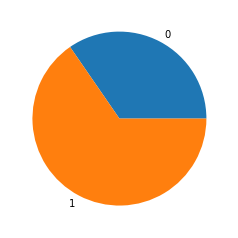

In [8]:
sizes=new_df.aclDiagnosis
x=pd.value_counts(sizes)

idx = pd.Int64Index([0,1])
Pie_Chart_df = pd.DataFrame(index = idx, data =(x))
plt.pie(Pie_Chart_df.aclDiagnosis,labels=Pie_Chart_df.index)
#their is one forth part of binary positive labels in all dataset

In [9]:
from PIL import Image
from skimage.transform import resize       
images_path=new_df['path']
image_list = []

for i in range(len(new_df)):
    with open(new_df['path'].iloc[i], 'rb') as file_handler: # Must use 'rb' as the data is binary
        image_array = pickle.load(file_handler)
    img=image_array[new_df['roiZ'].iloc[i], :, :]
    x=new_df["roiX"].iloc[i]
    y=new_df["roiY"].iloc[i]
    w=new_df["roiWidth"].iloc[i]
    h=new_df["roiHeight"].iloc[i]
    image_array=img[y:y+h, x:x+w]
    
    imageB_array = resize(image_array, (90, 90))
    image_list.append(imageB_array)
    
img_list=np.asarray(image_list)

Y=new_df.aclDiagnosis
Y=np.asarray(Y)
Y = to_categorical(Y, num_classes=2)
img_list = img_list.reshape(-1, 90,90,1)
img_list.shape


(578, 90, 90, 1)

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    img_list,Y, test_size=0.30, random_state=42)

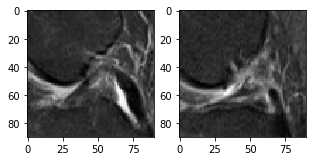

In [11]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(X_train[0], (90,90))
plt.imshow(curr_img, cmap='gray')

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(X_test[0], (90,90))
plt.imshow(curr_img, cmap='gray')

This is Our **Deep Nueral Network Model** On which we are going to Train our Images

In [12]:
from keras.models import Sequential
from keras.layers.core import Activation
from keras import regularizers
from keras.layers.convolutional import MaxPooling2D

In [13]:
def model (classes):
    model=Sequential()
        
        # conv2d set  =====> Conv2d====>relu=====>MaxPooling
    model.add(Conv2D(20,(5,5),padding="same"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    
    model.add(Conv2D(20,(5,5),padding="same"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    
    model.add(Conv2D(20,(5,5),padding="same"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    
   
    model.add(Flatten())
    
    model.add(Dense(64))
    model.add(Activation("relu"))
    model.add(Dropout(0.3))    
    model.add(Dense(32))
    model.add(Activation("relu"))
    model.add(Dropout(0.3))   
        
    model.add(Dense(classes))
    model.add(Activation("softmax"))
    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(lr=0.00001, decay=0),
                  metrics=['accuracy'])
    return model

Nice its giving **70% accuracy on binary data** lets apply some **augmentation** on the images to increase the number of images lets see how much it effect on our model

Now Lets see our model accuracy on Categorical Data
*     0:    Healthy
*     1:    half_Raptured
*     2:    Full_Raptured
    
    

In [16]:

   
images_path=df['path']
image_list = []

for i in range(len(df)):
    with open(df['path'].iloc[i], 'rb') as file_handler: # Must use 'rb' as the data is binary
        image_array = pickle.load(file_handler)
    img=image_array[df['roiZ'].iloc[i], :, :]
    x=df["roiX"].iloc[i]
    y=df["roiY"].iloc[i]
    w=df["roiWidth"].iloc[i]
    h=df["roiHeight"].iloc[i]
    image_array=img[y:y+h, x:x+w]
    
    imageB_array = resize(image_array, (90, 90))
    image_list.append(imageB_array)
    
img_list=np.asarray(image_list)

Y=df.aclDiagnosis
Y=np.asarray(Y)
Y = to_categorical(Y, num_classes=3)     


In [17]:
img_list = img_list.reshape(-1, 90,90,1)
img_list.shape

(1471, 90, 90, 1)

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    img_list,Y, test_size=0.10, random_state=42)


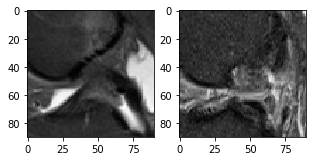

In [19]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(X_train[0], (90,90))
plt.imshow(curr_img, cmap='gray')

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(X_test[0], (90,90))
plt.imshow(curr_img, cmap='gray')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
1323/1323 [==============================] - 5s 4ms/step - loss: 0.6361 - acc: 0.6667
Epoch 2/10
1323/1323 [==============================] - 0s 231us/step - loss: 0.6349 - acc: 0.6667
Epoch 3/10
1323/1323 [==============================] - 0s 227us/step - loss: 0.6327 - acc: 0.6667
Epoch 4/10
1323/1323 [==============================] - 0s 230us/step - loss: 0.6277 - acc: 0.6667
Epoch 5/10
1323/1323 [==============================] - 0s 225us/step - loss: 0.6163 - acc: 0.6667
Epoch 6/10
1323/1323 [==============================] - 0s 226us/step - loss: 0.5961 - acc: 0.6667
Epoch 7/10
1323/1323 [==============================] - 0s 231us/step - loss: 0.5609 - acc: 0.6747
Epoch 8/10
1323/1323 [==============================] - 0s 227us/step - lo

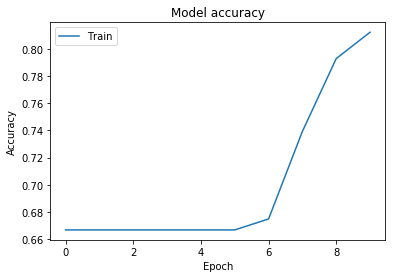

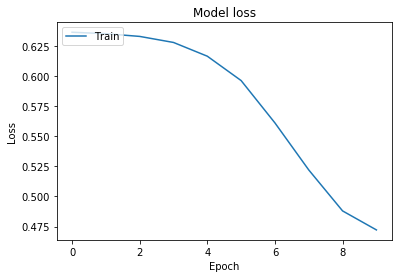

In [20]:

model=model(3)
history =model.fit(X_train, y_train, epochs=10)

# Plot training & validation accuracy values
plt.plot(history.history['acc'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [21]:
scores = model.evaluate(X_test,y_test)

print('Loss: %.3f' % scores[0])
print('Accuracy: %.3f' % scores[1])

148/148 [==============================] - 0s 825us/step
Loss: 0.453
Accuracy: 0.820


In [22]:
x=model.predict(X_test)

In [23]:
#images which are labeled as Half Raptured
for i in range(1,74):
    ind = np.argmax(x[i])
    
    if ind == 1 : print("Half Raptured Image" + str(i))
    if ind == 2 : print("Full Ruptured Image")

Enter Number Of image you want to check:  10


Healthy Image
Healthy Image


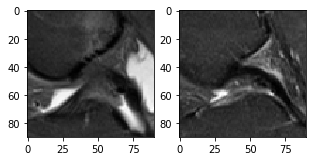

In [24]:
i=int(input("Enter Number Of image you want to check: "))
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(X_train[0], (90,90))
plt.imshow(curr_img, cmap='gray')

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(X_test[i], (90,90))
plt.imshow(curr_img, cmap='gray')

Predicted_label = np.argmax(x[i])
if Predicted_label == 0 : print("Healthy Image")
if Predicted_label == 1 : print("Half Raptured Image")
if Predicted_label == 2 : print("Full Ruptured Image")
    
    
True_Label = np.argmax(y_test[i])
if True_Label == 0 : print("Healthy Image")
if True_Label == 1 : print("Half Raptured Image")
if True_Label == 2 : print("Full Ruptured Image")

**True Labels**

In [25]:
for i in range(1,74):
    ind = np.argmax(y_test[i])

    if ind == 1 : print("Half Raptured Image " + str(i))
    if ind == 2 : print("Full Ruptured Image " + str(i))

Full Ruptured Image 2
Half Raptured Image 5
Half Raptured Image 14
Full Ruptured Image 15
Half Raptured Image 16
Half Raptured Image 17
Half Raptured Image 25
Full Ruptured Image 27
Half Raptured Image 28
Full Ruptured Image 29
Full Ruptured Image 32
Half Raptured Image 38
Half Raptured Image 43
Half Raptured Image 45
Half Raptured Image 47
Full Ruptured Image 56
Half Raptured Image 58
Half Raptured Image 61
Half Raptured Image 62
Half Raptured Image 64
Half Raptured Image 68
Full Ruptured Image 70
